# GESSO Demo

### Gene set expression quantification with GESSO

GESSO (Gene sEt activity Score analysis with Spatial lOcation) is a computational method for quantifying the overall expression levels of gene sets for spatial transcriptomics data.

Given spatial transcriptomics data and a user-provided gene set, GESSO returns a gene set activity score (GAS) for each spot.
GESSO can also systematically identify spots with elevated gene set activity through a permutation-based hypothesis test.

### Import the `gesso` package.

The `gesso` Python package can be easily downloaded from source. Simply run the following script in your terminal after ensuring Python and pip are available in your environment. We recommend installing GESSO in a new Python environment.

```bash
git clone https://github.com/YMa-Lab/GESSO.git
cd gesso
pip install .
cd ..
```

In [1]:
from pathlib import Path
import pandas as pd
import sys

project_directory = Path("__notebook__").resolve().parent.parent
sys.path.append(str(project_directory))

from gesso import GESSO

### Load the spatial transcriptomics data.

In this demo, we'll analyze the 10x Visium BRCA dataset. Let's first load and inspect the gene expression count data. The gene expression dataframe should be of dimension $N \times G$, where $N$ denotes the number of spots, and $G$ denotes the number of genes.

In [2]:
expression_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-count_data.pkl"
)
display(expression_df.head())

gene,DVL1,PIK3CD,MTOR,CASP9,WNT4,E2F2,HDAC1,CSF3R,SLC2A1,PTCH2,...,TLR8,VEGFD,ARAF,AR,IL2RG,FGF16,COL4A6,XIAP,FGF13,IKBKG
barcode,,,,,,,,,,,,,,,,,,,,,
GTAGACAACCGATGAA-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
ACAGATTAGGTTAGTG-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
TGGTATCGGTCTGTAT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ATTATCTCGACAGATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
TGAGATCAAATACTCA-1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Next, let's load and inspect the spatial location data. The location data is of dimension $N \times 2$.
Note: the index of the location dataframe must match the columns of the expression dataframe.

In [3]:
locations_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-location_data.pkl"
)
display(locations_df.head())

# note: SPLAT requires spatial locations to be in the form of a DataFrame containing columns "x" and "y"
locations_df = locations_df.rename(columns={"array_row": "x", "array_col": "y"})
display(locations_df.head())

,array_row,array_col
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


,x,y
barcode,,
GTAGACAACCGATGAA-1,7,55
ACAGATTAGGTTAGTG-1,7,57
TGGTATCGGTCTGTAT-1,7,59
ATTATCTCGACAGATC-1,7,61
TGAGATCAAATACTCA-1,7,63


Finally, let's load the gene set/pathway data. This data may be stored as a $G \times n_\text{genesets}$ binary matrix.

In [4]:
genesets_df: pd.DataFrame = pd.read_pickle(
    project_directory / "demo_data" / "10xVisiumBRCA-pathways_data.pkl"
)
display(genesets_df.head())

# we can also work with gene sets as dictionaries mapping gene set name to list of genes
genesets_dict = {
    geneset: list(genesets_df.index[genesets_df[geneset] == 1])
    for geneset in genesets_df.columns
}
print(genesets_dict)

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
DVL1,1,0
PIK3CD,1,0
MTOR,1,0
CASP9,1,0
WNT4,1,0


{'KEGG_PATHWAYS_IN_CANCER': ['DVL1', 'PIK3CD', 'MTOR', 'CASP9', 'WNT4', 'E2F2', 'HDAC1', 'CSF3R', 'SLC2A1', 'PTCH2', 'PIK3R3', 'JUN', 'JAK1', 'WNT2B', 'NRAS', 'PIAS3', 'ARNT', 'NTRK1', 'RXRG', 'FASLG', 'LAMC1', 'LAMC2', 'TPR', 'PTGS2', 'RASSF5', 'LAMB3', 'TRAF5', 'TGFB2', 'WNT9A', 'WNT3A', 'EGLN1', 'FH', 'AKT3', 'SOS1', 'EPAS1', 'MSH2', 'MSH6', 'TGFA', 'CTNNA2', 'TCF7L1', 'PAX8', 'RALB', 'GLI2', 'ITGA6', 'ITGAV', 'STAT1', 'CASP8', 'FZD7', 'FZD5', 'FN1', 'STK36', 'WNT6', 'WNT10A', 'COL4A4', 'VHL', 'PPARG', 'RAF1', 'WNT7A', 'RARB', 'TGFBR2', 'MLH1', 'CTNNB1', 'LAMB2', 'RHOA', 'RASSF1', 'WNT5A', 'APPL1', 'MITF', 'TFG', 'CBLB', 'GSK3B', 'PIK3CB', 'MECOM', 'PLD1', 'PIK3CA', 'DVL3', 'FGF12', 'CTBP1', 'FGFR3', 'PDGFRA', 'KIT', 'CXCL8', 'FGF5', 'MAPK10', 'NFKB1', 'LEF1', 'EGF', 'FGF2', 'HHIP', 'VEGFC', 'CASP3', 'SKP2', 'FGF10', 'ITGA2', 'PIK3R1', 'MSH3', 'APC', 'TCF7', 'WNT8A', 'CTNNA1', 'FGF1', 'CSF1R', 'PDGFRB', 'FGF18', 'MAPK9', 'E2F3', 'RXRB', 'PPARD', 'CDKN1A', 'VEGFA', 'HSP90AB1', 'LAMA4

### Use GESSO to compute gene set activity scores

This is the simplest use case for GESSO. Simply inpute the data and generate an 
activity scores report.

GESSO (info): Identified 334 common genes in the gene set and expression data. 
GESSO (info): Identified 2518 common spots in the location and expression data. 
GESSO (info): Normalized expression data with strategy 'normalize-log1p'. 
GESSO (info): Model initialization complete. 
GESSO (info): Beginning activity score computation for 2 gene sets with 2 jobs. Method 
               used: cpu. 
GESSO (info): (Job 2: 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT) 
               Activity score computation for 
               WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT 
               completed in 0.42 seconds. 
GESSO (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 1.6 seconds. 


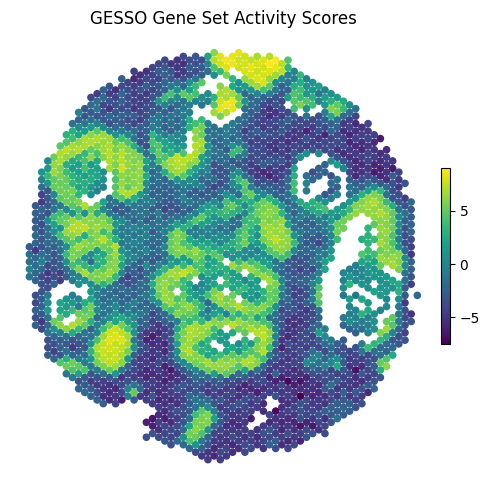

In [5]:
model = GESSO(
    expression_df=expression_df,
    locations_df=locations_df,
    genesets_df=genesets_df,
    k=6,  # increase k to increase spatial smoothing effect
    normalize_counts_method="normalize-log1p",  # easily normalize counts for non-preprocessed data
)
# compute activity scores for all gene sets in genesets_df
gas_report = model.compute_gas(
    beta=0.33,  # increase beta to increase spatial smoothing strength; must be between 0 and 1
    compute_method="cpu",  # use "gpu" for GPU acceleration if available
)
# quickly plot spatial map of activity scores for a specific gene set
figure = gas_report.plot_gas_spatial_map(
    geneset="KEGG_PATHWAYS_IN_CANCER",  # specify the gene set of interest
    size=20,  # dot size
    cmap="viridis",
    figsize=(5, 5),
)  # returns a matplotlib Figure object
display(figure)

You can easily retrieve relevant data in `pd.DataFrame` form from the GESSO gene set activity scores report.

In [6]:
display(gas_report.gas_df())
display(gas_report.metagene_df(geneset="KEGG_PATHWAYS_IN_CANCER"))

,KEGG_PATHWAYS_IN_CANCER,WP_INTERACTIONS_BETWEEN_IMMUNE_CELLS_AND_MICRORNAS_IN_TUMOR_MICROENVIRONMENT
barcode,,
AAATGGTCAATGTGCC-1,2.373060,-2.481073
CTATGTCACTAGCCCA-1,4.856651,-2.130031
GAAGTGATTTATCGTG-1,5.779067,-1.668737
TCGTATTACCCATTGC-1,-3.877588,-0.426743
TATCGATGATTAAACG-1,-2.074737,2.382555
...,...,...
CGCCAAGAAGCCGAGT-1,-3.975754,2.342055
TATCTACCACAGCGGG-1,0.396677,-0.912567
AGATATAATACGACTA-1,7.129272,-3.069732


,KEGG_PATHWAYS_IN_CANCER
ERBB2,0.209586
RARA,0.174598
PRKCA,0.174346
CDH1,0.168773
VEGFA,0.157960
...,...
GSTP1,-0.127367
PDGFRB,-0.139567
CSF1R,-0.144330
FOS,-0.167214


You can also work directly with gene sets in dictionary form.

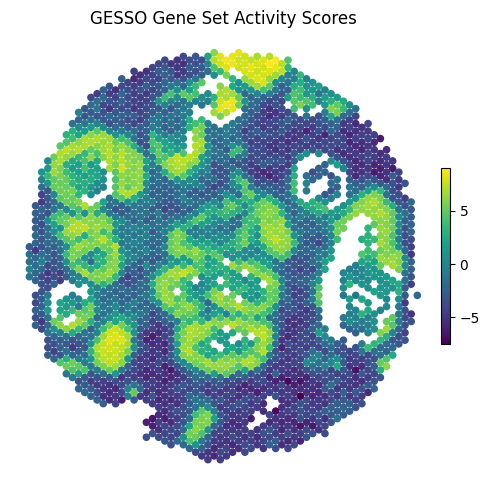

In [7]:
model_alt = GESSO(
    expression_df=expression_df,
    locations_df=locations_df,
    k=6,
    normalize_counts_method="normalize-log1p",
    verbose=False,  # set verbose to False to suppress console output
)
gas_report = model_alt.compute_gas(
    genesets_dict=genesets_dict,
    beta=0.33,
    compute_method="cpu"
)
gas_report.plot_gas_spatial_map(
    geneset="KEGG_PATHWAYS_IN_CANCER",
    size=20,
    cmap="viridis",
    figsize=(5, 5)
)

### Use GESSO to systematically identify spots with significantly elevated gene set activity
Please note that the output of the permutation-based hypothesis test varies with the total number of genes in the dataset. The example dataset used in this demo contains a subset of all genes from the original dataset.

In [8]:
model = GESSO(
    expression_df=expression_df,
    locations_df=locations_df,
    genesets_df=genesets_df,
    k=6,
    normalize_counts_method="normalize-log1p",
)
htest_report = model.htest_elevated_gas(
    geneset="KEGG_PATHWAYS_IN_CANCER", 
    n_permutations=100, # number of random gene sets to sample for the test
    n_jobs=4            # set number of CPUs
)

GESSO (info): Identified 334 common genes in the gene set and expression data. 
GESSO (info): Identified 2518 common spots in the location and expression data. 
GESSO (info): Normalized expression data with strategy 'normalize-log1p'. 
GESSO (info): Model initialization complete. 
GESSO (info): Beginning activity score computation for 101 gene sets with 4 jobs. Method 
               used: cpu. 
GESSO (info): (Job 1: KEGG_PATHWAYS_IN_CANCER) Activity score computation for 
               KEGG_PATHWAYS_IN_CANCER completed in 1.95 seconds. 
GESSO (info): (Job 2: random_geneset_0) Activity score computation for random_geneset_0 
               completed in 1.95 seconds. 
GESSO (info): (Job 4: random_geneset_2) Activity score computation for random_geneset_2 
               completed in 1.95 seconds. 
GESSO (info): (Job 3: random_geneset_1) Activity score computation for random_geneset_1 
               completed in 1.96 seconds. 
GESSO (info): (Job 5: random_geneset_3) Activity score comp

,x,y,gas,p
barcode,,,,
AAATGGTCAATGTGCC-1,33,51,2.373060,0.07
CTATGTCACTAGCCCA-1,30,66,4.856651,0.08
GAAGTGATTTATCGTG-1,39,47,5.779067,0.04
TCGTATTACCCATTGC-1,37,25,-3.877588,1.00
TATCGATGATTAAACG-1,23,49,-2.074737,0.92
...,...,...,...,...
CGCCAAGAAGCCGAGT-1,39,17,-3.975754,0.92
TATCTACCACAGCGGG-1,42,60,0.396677,0.08
AGATATAATACGACTA-1,64,72,7.129272,0.05


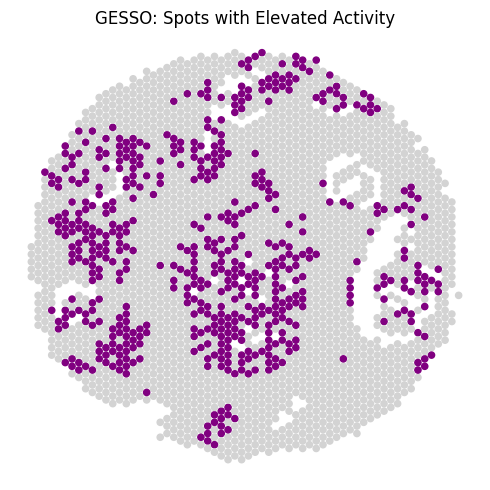

In [9]:
display(htest_report.htest_df())
htest_report.plot_pval_spatial_map(
    size=20,
    significance_threshold=0.05
)